<font size="+3"><strong>Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components</strong></font>

# Prepare Data

## Import 

In [63]:
# # used to change filepaths
# import os

# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from IPython.display import display
# %matplotlib inline

# import pandas as pd
# import numpy as np

# from PIL import Image

# from skimage.feature import hog
# from skimage.color import rgb2gray

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# from sklearn.model_selection import train_test_split

# from sklearn.svm import SVC

# from sklearn.metrics import roc_curve, auc, accuracy_score

In [64]:
# Importing necessary libraries 
import warnings

import tensorflow as tf
# assert tf.__version__.startswith('2')

from google.colab import files # For downloading Files
from google.colab import drive # For Mounting Google drive
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter(action="ignore", category=FutureWarning)

In [65]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Moving to the necessary folder

%cd drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset

[Errno 2] No such file or directory: 'drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset'
/content/drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset


In [67]:
%ls -la

total 10213
drwx------  2 root root     4096 May  9 18:45 Capacitor/
-rw-------  1 root root      137 Jun 11 13:37 labels.txt
-rw-------  1 root root 10432312 Jun 10 17:30 mobilenet_v2_naive_11model.tflite
drwx------  2 root root     4096 Jun  9 11:08 path/
drwx------  2 root root     4096 May  9 18:45 Resistor/
drwx------  2 root root     4096 Jun  6 03:09 save/
drwx------  2 root root     4096 May  9 18:45 Transistor/
drwx------ 13 root root     4096 May  9 18:45 upload/


## Split

In [68]:
# Setting the base directory and defines constants for the data generator and model training

base_dir = 'upload'
base_dir = pathlib.Path(base_dir)
VALIDATION_SPLIT = 0.3
SEED = 100
BATCH_SIZE = 32
# IMAGE_SIZE = 128
IMAGE_SIZE = 64
base_learning_rate = 0.00001

In [69]:
# Creating the Image data generator with data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
    )

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    seed=SEED,
    subset='validation')

Found 7698 images belonging to 11 classes.
Found 3298 images belonging to 11 classes.


In [70]:
num_classes=11

for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 64, 64, 3), (32, 11))

In [71]:
# Generator is used to retrieve batch of images and labels for training

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'Battery': 0, 'Capacitor': 1, 'Cartridge Fuse': 2, 'Circuit Breaker': 3, 'Filament Bulb': 4, 'Induction Coil': 5, 'Integrated Micro-circuit': 6, 'LED': 7, 'Resistor': 8, 'Stabilizer': 9, 'Transistor': 10}


In [72]:
!cat labels.txt

Battery
Capacitor
Cartridge Fuse
Circuit Breaker
Filament Bulb
Induction Coil
Integrated Micro-circuit
LED
Resistor
Stabilizer
Transistor

## Explore

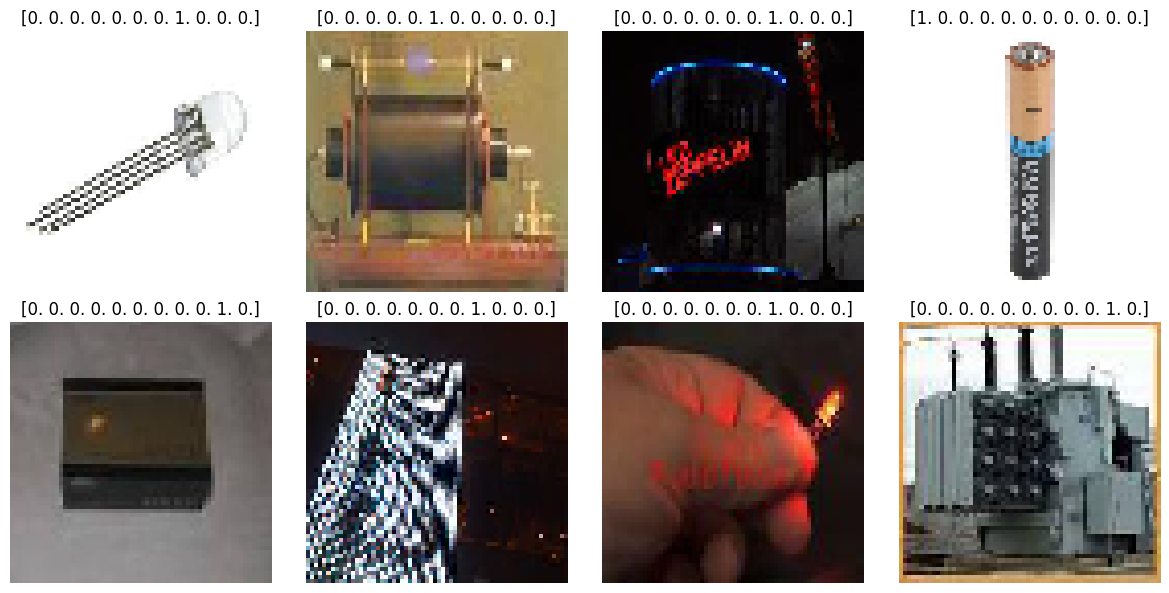

In [73]:
# Display a few sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, (image, label) in zip(axes, train_generator):
    ax.imshow(image[0])
    ax.set_title(label[0])
    ax.axis('off')

plt.tight_layout()
plt.show()


Examine RGB values in an Image matrix


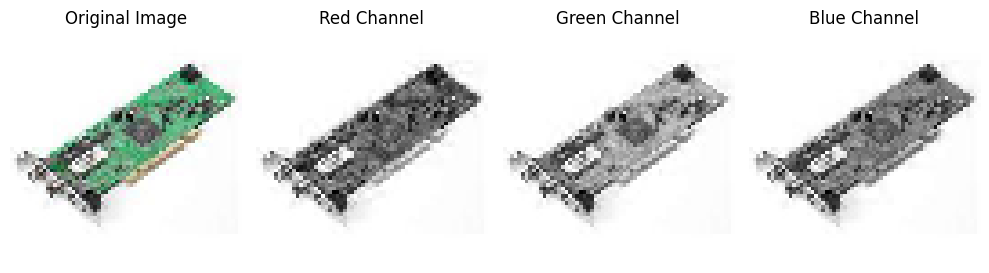

In [74]:
# Accessing the first image in the batch
image = image_batch[0]

# Splitting the image into RGB channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Plotting the RGB channels
plt.figure(figsize=(10, 4))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()


In [75]:
# Accessing the first image in the batch
sample_image = train_generator[0][0][0]  # First image in the first batch

# Getting the size of the sample image
image_height, image_width, _ = sample_image.shape

# Printing the size
print(f"Sample image size: {image_width} x {image_height}")


Sample image size: 64 x 64


# Build Model

<p>A convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.</p>

<p>Building a CNN begins with specifying the model type. In our case, we'll use a <a href="https://keras.io/getting-started/sequential-model-guide/">Sequential</a> model, which is a linear stack of layers. We'll then add on it.</p>

A complete neural network architecture will have a number of other layers that are designed to play a specific role in the overall functioning of the network. Much deep learning research is about how to structure these layers into coherent systems.</p>
<p>layers:</p>
<ul>

- `tf.keras.Sequential`: This is the base model class in Keras that allows you to stack layers sequentially.

- `tf.keras.Input(shape=IMG_SHAPE)`: This creates an input layer with the specified shape (`IMG_SHAPE`). The input shape represents the shape of the input images that will be fed into the model.

- `tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)`: This layer randomly applies zoom augmentation to the input images. It randomly zooms in or out of the images by a factor of 0.2.

- `tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)`: This layer randomly applies translation augmentation to the input images. It randomly shifts the images horizontally and vertically by a maximum of 0.2.

- `base_model`: This is a reference to a pre-trained model that will be used as a base for feature extraction. You need to replace `base_model` with an actual pre-trained model, such as ResNet50 or InceptionV3.

- `tf.keras.layers.GlobalAveragePooling2D()`: This layer performs global average pooling on the output of the base model. It reduces the spatial dimensions of the feature maps to a fixed size, regardless of the input image size.

- `tf.keras.layers.Dense(512, activation='relu')`: This adds a fully connected dense layer with 512 units and ReLU activation function. It serves as a hidden layer to learn complex representations from the pooled features.

- `tf.keras.layers.BatchNormalization()`: This layer normalizes the activations of the previous layer by adjusting and scaling them. It helps in stabilizing the learning process and improving generalization.

- `tf.keras.layers.Dropout(0.5)`: This layer applies dropout regularization to the inputs. It randomly sets a fraction of input units to 0 at each update during training, which helps in reducing overfitting.

- `tf.keras.layers.Dense(num_classes, activation='softmax')`: This adds the final dense layer with `num_classes` units (representing the number of classes in your classification problem) and softmax activation function. It outputs the predicted probabilities for each class.

Each layer in the model contributes to the overall architecture and helps in learning useful representations from the input images. The combination of data augmentation, base model, pooling, and fully connected layers helps in capturing and extracting meaningful features for classification tasks.
</ul>
<p>To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping <code>3,669,249</code> paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

## Baseline Model / Models

In [76]:
# MobileNetV2 base model

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Experiementing with ResNet50
# base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [77]:
base_model.trainable = False

In [ ]:
# First Model I tested

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     #tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [78]:
#Experimented with this Model

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [79]:
#Experimented with this too

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [80]:
# Tried This too

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [82]:
# Final Architecture.

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


## Iterate and Evaluate

In [83]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_5 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_5 (Rando  (None, 64, 64, 3)        0         
 mTranslation)                                                   
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                      

In [85]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 6


In [86]:
loss0, accuracy0 = model.evaluate(val_generator)

  5/104 [>.............................] - ETA: 12:42 - loss: 3.4695 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


104/104 [==============================] - 664s 6s/step - loss: 3.2023 - accuracy: 0.1261


In [104]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    # min_delta=0,
    patience=5,
    verbose=1,
    mode='max')

# checkpoint_filepath = 'path/best_model'

# # Create a ModelCheckpoint callback to save the best model
# mcc = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )


In [88]:
initial_epochs = 5

In [89]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=initial_epochs, 
                    validation_data=val_generator,
                    callbacks=[es], 
                    validation_steps=len(val_generator))

Epoch 1/5
241/241 [==============================] - 1541s 6s/step - loss: 1.3159 - accuracy: 0.6141 - val_loss: 1.1869 - val_accuracy: 0.6574
Epoch 2/5
241/241 [==============================] - 63s 261ms/step - loss: 0.8675 - accuracy: 0.7215 - val_loss: 1.1175 - val_accuracy: 0.6822
Epoch 3/5
241/241 [==============================] - 71s 294ms/step - loss: 0.7756 - accuracy: 0.7450 - val_loss: 1.0867 - val_accuracy: 0.6753
Epoch 4/5
241/241 [==============================] - 68s 284ms/step - loss: 0.7128 - accuracy: 0.7694 - val_loss: 1.0361 - val_accuracy: 0.6862
Epoch 5/5
241/241 [==============================] - 67s 277ms/step - loss: 0.6614 - accuracy: 0.7805 - val_loss: 1.0447 - val_accuracy: 0.6941


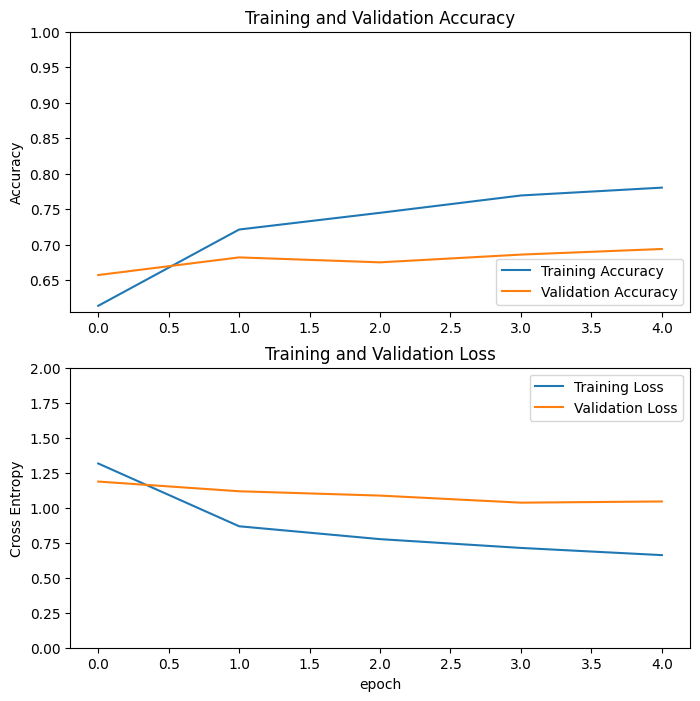

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning / Iterate and Evaluate



In [ ]:
# # Set base_model.trainable = True to enable fine-tuning
# base_model.trainable = True

# # Compile the model with an appropriate optimizer and loss function
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

# # Print a summary of the model
# model.summary()


In [ ]:
# tf.keras.layers.Dropout(0.6),


In [91]:
base_model.trainable = True

In [92]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [93]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [94]:
print(base_learning_rate)

1e-05


In [95]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_5 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_5 (Rando  (None, 64, 64, 3)        0         
 mTranslation)                                                   
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                      

In [97]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [98]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=total_epochs, 
                         initial_epoch=history.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 5/30
 21/241 [=>............................] - ETA: 1:11 - loss: 1.9328 - accuracy: 0.4702

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 100s 394ms/step - loss: 1.2317 - accuracy: 0.6273 - val_loss: 5.0138 - val_accuracy: 0.3457
Epoch 6/30
241/241 [==============================] - 94s 389ms/step - loss: 0.7549 - accuracy: 0.7619 - val_loss: 5.4749 - val_accuracy: 0.3372
Epoch 7/30
241/241 [==============================] - 92s 380ms/step - loss: 0.6047 - accuracy: 0.8127 - val_loss: 2.6251 - val_accuracy: 0.6295
Epoch 8/30
241/241 [==============================] - 92s 380ms/step - loss: 0.4992 - accuracy: 0.8400 - val_loss: 2.9584 - val_accuracy: 0.6555
Epoch 9/30
241/241 [==============================] - 92s 383ms/step - loss: 0.4236 - accuracy: 0.8649 - val_loss: 3.6603 - val_accuracy: 0.5515
Epoch 10/30
241/241 [==============================] - 88s 365ms/step - loss: 0.3946 - accuracy: 0.8704 - val_loss: 3.8310 - val_accuracy: 0.5340
Epoch 10: early stopping


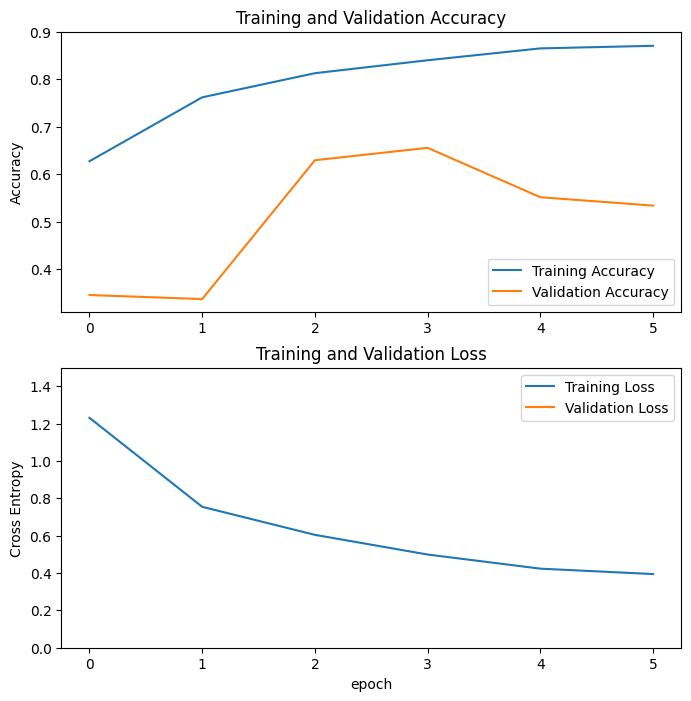

In [99]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [100]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [101]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Nadam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_5 (RandomZoom)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_5 (Rando  (None, 64, 64, 3)        0         
 mTranslation)                                                   
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                      

In [105]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine1 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=total_epochs, 
                         initial_epoch=history_fine.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 10/30


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 104s 388ms/step - loss: 0.4914 - accuracy: 0.8426 - val_loss: 4.8647 - val_accuracy: 0.5370
Epoch 11/30
241/241 [==============================] - 89s 370ms/step - loss: 0.4289 - accuracy: 0.8605 - val_loss: 8.8611 - val_accuracy: 0.3623
Epoch 12/30
241/241 [==============================] - 93s 386ms/step - loss: 0.3564 - accuracy: 0.8876 - val_loss: 3.5466 - val_accuracy: 0.4857
Epoch 13/30
241/241 [==============================] - 93s 386ms/step - loss: 0.3318 - accuracy: 0.9002 - val_loss: 3.4642 - val_accuracy: 0.5573
Epoch 14/30
241/241 [==============================] - 93s 387ms/step - loss: 0.2809 - accuracy: 0.9098 - val_loss: 6.2007 - val_accuracy: 0.4633
Epoch 15/30
241/241 [==============================] - 93s 386ms/step - loss: 0.2533 - accuracy: 0.9228 - val_loss: 2.6161 - val_accuracy: 0.6392
Epoch 16/30
241/241 [==============================] - 89s 369ms/step - loss: 0.2302 - accuracy: 0.9254 - val_loss: 2.3267 - val_accura

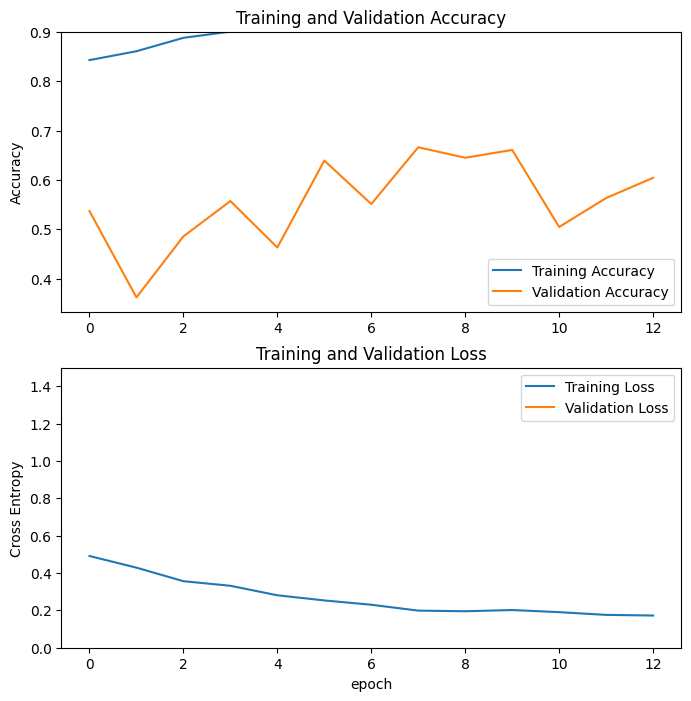

In [106]:
acc = history_fine1.history['accuracy']
val_acc = history_fine1.history['val_accuracy']

loss = history_fine1.history['loss']
val_loss = history_fine1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine2 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=total_epochs, 
                         initial_epoch=history_fine1.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 22/30
  3/241 [..............................] - ETA: 57s - loss: 0.2123 - accuracy: 0.8958

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 101s 417ms/step - loss: 0.1474 - accuracy: 0.9495 - val_loss: 2.1130 - val_accuracy: 0.6868
Epoch 23/30
241/241 [==============================] - 90s 373ms/step - loss: 0.1707 - accuracy: 0.9443 - val_loss: 2.4971 - val_accuracy: 0.6364
Epoch 24/30
241/241 [==============================] - 89s 370ms/step - loss: 0.1404 - accuracy: 0.9544 - val_loss: 2.1895 - val_accuracy: 0.6862
Epoch 25/30
241/241 [==============================] - 88s 366ms/step - loss: 0.1307 - accuracy: 0.9600 - val_loss: 2.0020 - val_accuracy: 0.7071
Epoch 26/30
241/241 [==============================] - 92s 380ms/step - loss: 0.1359 - accuracy: 0.9544 - val_loss: 2.0819 - val_accuracy: 0.6795
Epoch 27/30
241/241 [==============================] - 92s 381ms/step - loss: 0.1157 - accuracy: 0.9630 - val_loss: 2.7607 - val_accuracy: 0.6131
Epoch 28/30
241/241 [==============================] - 88s 364ms/step - loss: 0.1292 - accuracy: 0.9578 - val_loss: 2.0430 - val_accura

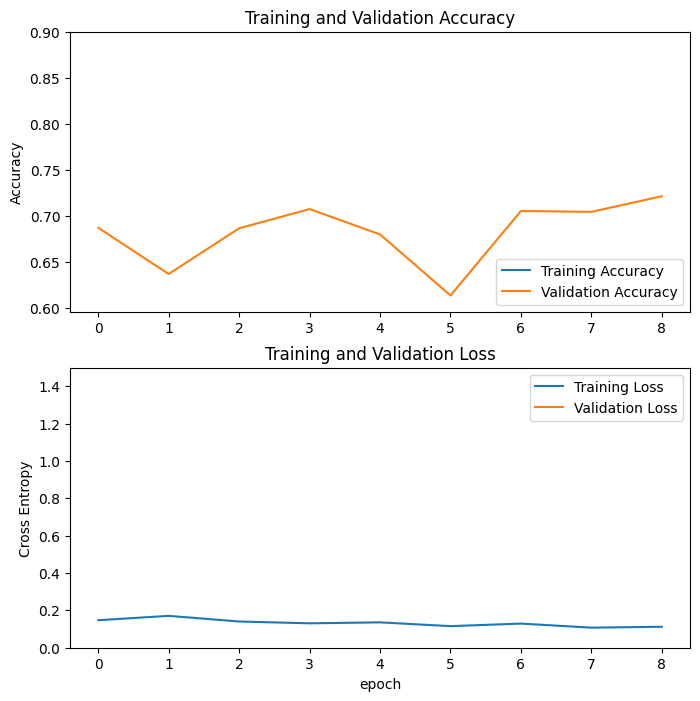

In [108]:
acc = history_fine2.history['accuracy']
val_acc = history_fine2.history['val_accuracy']

loss = history_fine2.history['loss']
val_loss = history_fine2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [112]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine3 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=50, 
                         initial_epoch=history_fine2.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 30/50
  7/241 [..............................] - ETA: 1:06 - loss: 0.0893 - accuracy: 0.9643

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 101s 419ms/step - loss: 0.1212 - accuracy: 0.9604 - val_loss: 1.8795 - val_accuracy: 0.7165
Epoch 31/50
241/241 [==============================] - 96s 398ms/step - loss: 0.1163 - accuracy: 0.9639 - val_loss: 2.2080 - val_accuracy: 0.6816
Epoch 32/50
241/241 [==============================] - 93s 385ms/step - loss: 0.1053 - accuracy: 0.9684 - val_loss: 2.3334 - val_accuracy: 0.6525
Epoch 33/50
241/241 [==============================] - 104s 430ms/step - loss: 0.1005 - accuracy: 0.9687 - val_loss: 1.8123 - val_accuracy: 0.7486
Epoch 34/50
241/241 [==============================] - 95s 395ms/step - loss: 0.0981 - accuracy: 0.9669 - val_loss: 1.9499 - val_accuracy: 0.7126
Epoch 35/50
241/241 [==============================] - 94s 389ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 1.8903 - val_accuracy: 0.7238
Epoch 36/50
241/241 [==============================] - 92s 381ms/step - loss: 0.0899 - accuracy: 0.9735 - val_loss: 2.0941 - val_accur

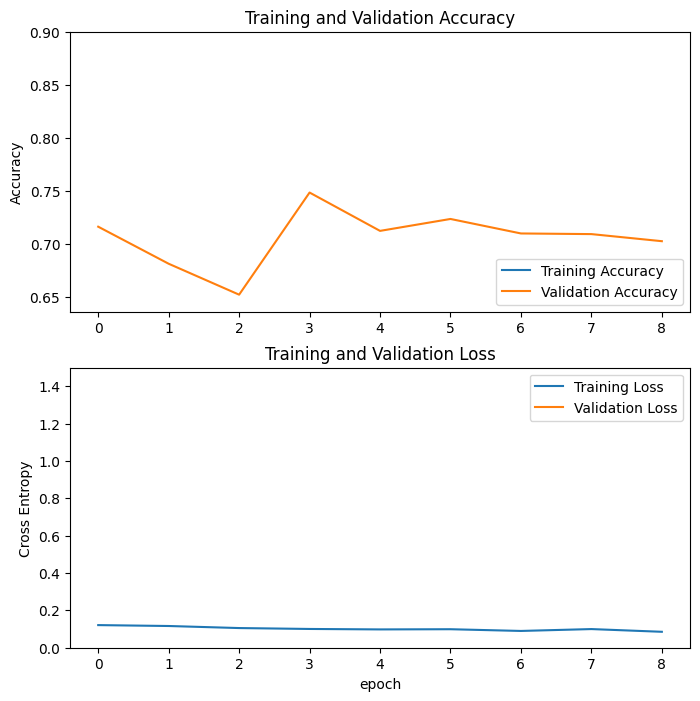

In [113]:
acc = history_fine3.history['accuracy']
val_acc = history_fine3.history['val_accuracy']

loss = history_fine3.history['loss']
val_loss = history_fine3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine4 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=50, 
                         initial_epoch=history_fine3.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 38/50
  8/241 [..............................] - ETA: 1:02 - loss: 0.0800 - accuracy: 0.9570

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 95s 393ms/step - loss: 0.0894 - accuracy: 0.9709 - val_loss: 2.7401 - val_accuracy: 0.6604
Epoch 39/50
241/241 [==============================] - 95s 396ms/step - loss: 0.0974 - accuracy: 0.9687 - val_loss: 2.1498 - val_accuracy: 0.7068
Epoch 40/50
241/241 [==============================] - 98s 406ms/step - loss: 0.0775 - accuracy: 0.9747 - val_loss: 2.2758 - val_accuracy: 0.7129
Epoch 41/50
241/241 [==============================] - 90s 372ms/step - loss: 0.0768 - accuracy: 0.9769 - val_loss: 2.0496 - val_accuracy: 0.7174
Epoch 42/50
241/241 [==============================] - 101s 419ms/step - loss: 0.0820 - accuracy: 0.9745 - val_loss: 2.1089 - val_accuracy: 0.7135
Epoch 43/50
241/241 [==============================] - 96s 397ms/step - loss: 0.0812 - accuracy: 0.9766 - val_loss: 2.1762 - val_accuracy: 0.6822
Epoch 44/50
241/241 [==============================] - 93s 384ms/step - loss: 0.0901 - accuracy: 0.9717 - val_loss: 2.3998 - val_accura

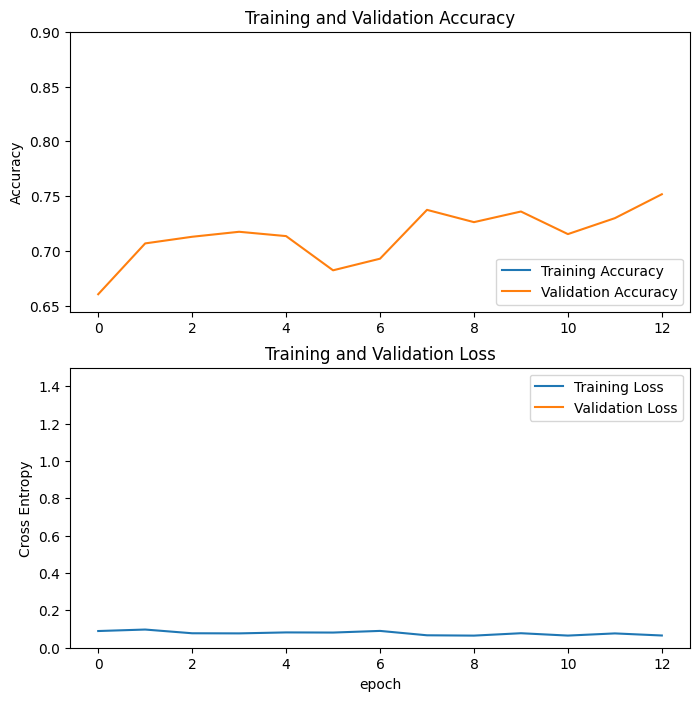

In [123]:
acc = history_fine4.history['accuracy']
val_acc = history_fine4.history['val_accuracy']

loss = history_fine4.history['loss']
val_loss = history_fine4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer = tf.keras.optimizers.Nadam(lr=base_learning_rate/10),
#               metrics=['accuracy'])

In [126]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine5 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=100, 
                         initial_epoch=history_fine4.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 50/100
 15/241 [>.............................] - ETA: 1:30 - loss: 0.0949 - accuracy: 0.9812

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


241/241 [==============================] - 99s 409ms/step - loss: 0.0603 - accuracy: 0.9825 - val_loss: 1.6563 - val_accuracy: 0.7717
Epoch 51/100
241/241 [==============================] - 92s 383ms/step - loss: 0.0555 - accuracy: 0.9831 - val_loss: 1.6337 - val_accuracy: 0.7756
Epoch 52/100
241/241 [==============================] - 92s 381ms/step - loss: 0.0587 - accuracy: 0.9808 - val_loss: 1.7366 - val_accuracy: 0.7656
Epoch 53/100
241/241 [==============================] - 94s 390ms/step - loss: 0.0668 - accuracy: 0.9792 - val_loss: 1.6637 - val_accuracy: 0.7653
Epoch 54/100
241/241 [==============================] - 95s 393ms/step - loss: 0.0673 - accuracy: 0.9783 - val_loss: 1.9933 - val_accuracy: 0.7183
Epoch 55/100
241/241 [==============================] - 95s 395ms/step - loss: 0.0582 - accuracy: 0.9808 - val_loss: 1.8670 - val_accuracy: 0.7229
Epoch 56/100
241/241 [==============================] - 86s 358ms/step - loss: 0.0726 - accuracy: 0.9779 - val_loss: 1.9440 - val_a

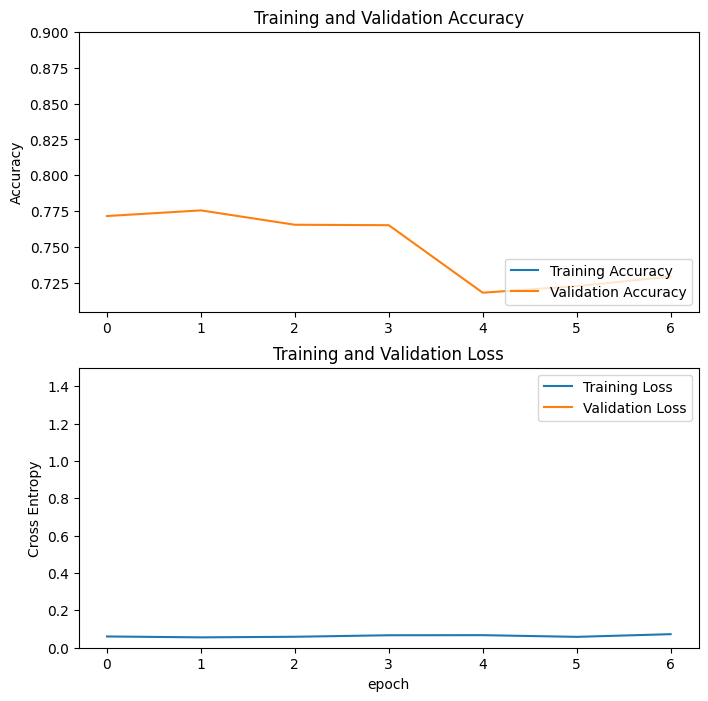

In [127]:
acc = history_fine5.history['accuracy']
val_acc = history_fine5.history['val_accuracy']

loss = history_fine5.history['loss']
val_loss = history_fine5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [132]:
# total_epochs1 =  initial_epochs + fine_tune_epochs
history_fine6 = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=100, 
                         initial_epoch=history_fine5.epoch[-1],
                         callbacks=[es], 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 56/100
241/241 [==============================] - 102s 424ms/step - loss: 0.0509 - accuracy: 0.9835 - val_loss: 1.6858 - val_accuracy: 0.7483
Epoch 57/100
241/241 [==============================] - 98s 407ms/step - loss: 0.0546 - accuracy: 0.9825 - val_loss: 1.5077 - val_accuracy: 0.7647
Epoch 58/100
241/241 [==============================] - 103s 429ms/step - loss: 0.0439 - accuracy: 0.9849 - val_loss: 1.8019 - val_accuracy: 0.7429
Epoch 59/100
241/241 [==============================] - 115s 475ms/step - loss: 0.0522 - accuracy: 0.9848 - val_loss: 2.2151 - val_accuracy: 0.7165
Epoch 60/100
241/241 [==============================] - 101s 421ms/step - loss: 0.0449 - accuracy: 0.9835 - val_loss: 1.5806 - val_accuracy: 0.7796
Epoch 61/100
241/241 [==============================] - 101s 418ms/step - loss: 0.0503 - accuracy: 0.9843 - val_loss: 1.6712 - val_accuracy: 0.7605
Epoch 62/100
241/241 [==============================] - 89s 368ms/step - loss: 0.0439 - accuracy: 0.9857 - val_lo

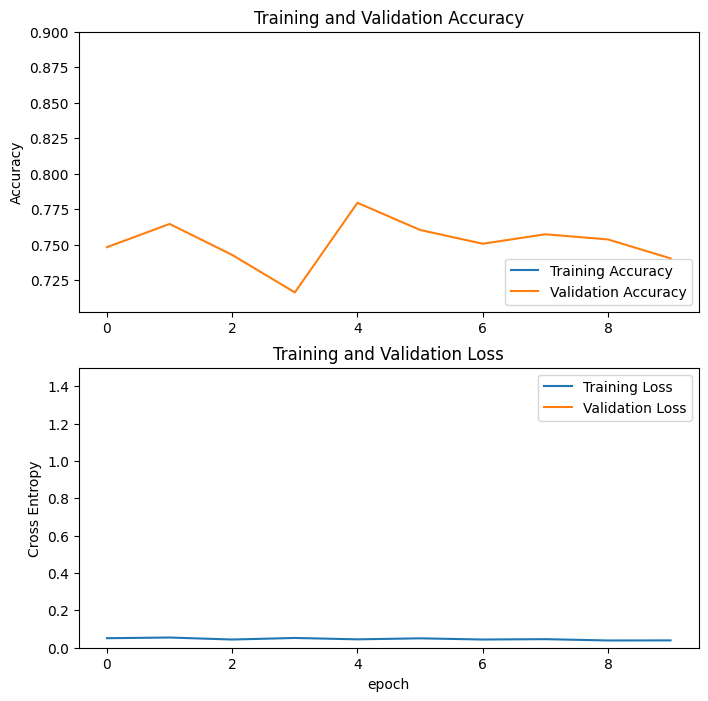

In [133]:
acc = history_fine6.history['accuracy']
val_acc = history_fine6.history['val_accuracy']

loss = history_fine6.history['loss']
val_loss = history_fine6.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Precision, Recall, and F1 Score

In [137]:
# Make predictions on the validation data
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate Precision
precision = precision_score(y_true, y_pred_labels, average='macro')

# Calculate Recall
recall = recall_score(y_true, y_pred_labels, average='macro')

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_labels, average='macro')

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


  2/104 [..............................] - ETA: 16s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


104/104 [==============================] - 18s 174ms/step
Precision: 0.09
Recall: 0.09
F1 Score: 0.09


Precision-Recall Curve

Confusion Matrix

  7/104 [=>............................] - ETA: 15s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


104/104 [==============================] - 19s 181ms/step


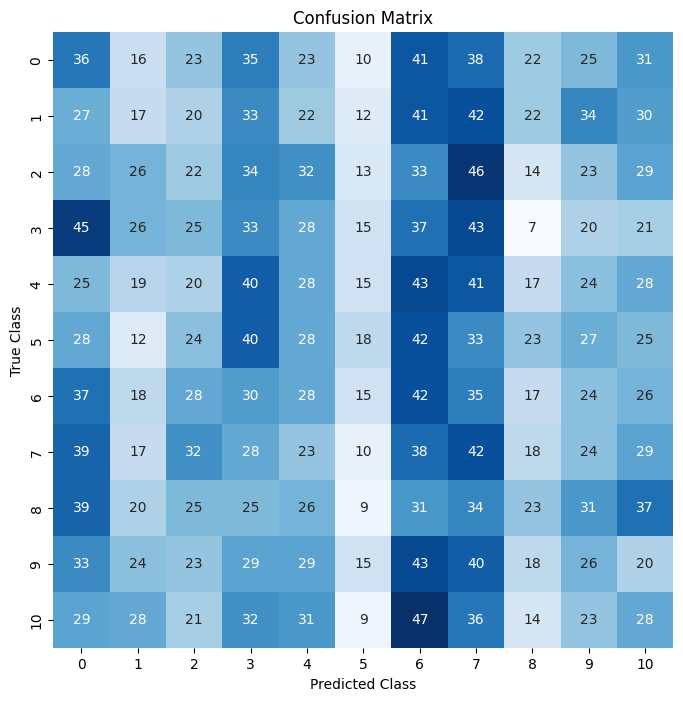

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the validation data
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


ROC Curve + AUC

104/104 [==============================] - 21s 200ms/step


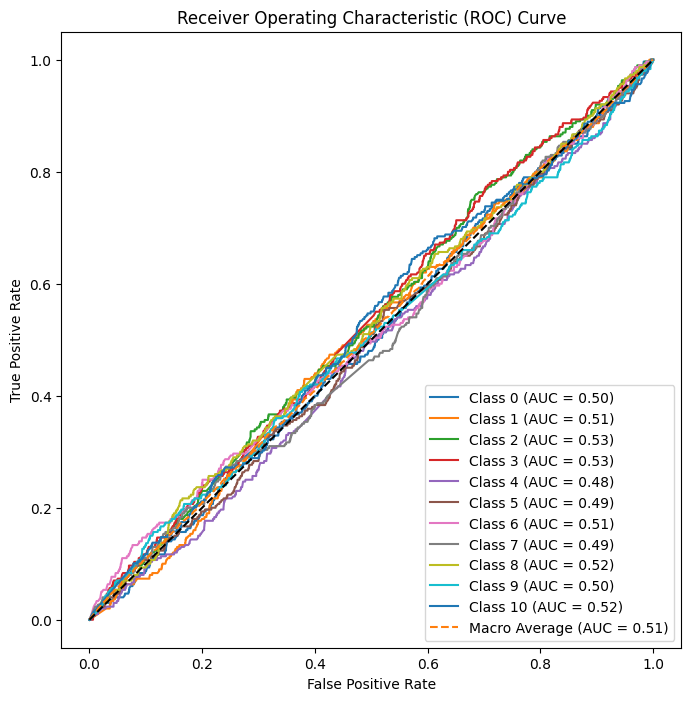

In [134]:

# Step 1: Make predictions on the validation data
y_pred_prob = model.predict(val_generator)
y_true = val_generator.classes
num_classes = val_generator.num_classes

# Step 2: Convert probabilities to binary matrix
y_pred_bin = np.argmax(y_pred_prob, axis=1)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Compute macro-average ROC curve and AUC
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(num_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= num_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Step 5: Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_macro, tpr_macro, label=f'Macro Average (AUC = {roc_auc_macro:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


# Saving Models

In [ ]:
# Naive Model

saved_model_dir = 'save/naive_model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_naive_11model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
files.download('mobilenet_v2_naive_11model.tflite')
files.download('labels.txt')

In [135]:
# Fine Tuned Model

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_fine_tuned11.tflite', 'wb') as f:
    f.write(tflite_model)

In [136]:
files.download('mobilenet_v2_fine_tuned11.tflite')
# files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>